# 2022-10-24 • N-to-1 with lognormal inputs (for real now)

## Imports

In [1]:
#

In [17]:
Revise.retry()

In [22]:
@time using MyToolbox
@time using Sciplotlib
@time using SpikeLab
@time using VoltoMapSim

  0.001573 seconds (347 allocations: 21.695 KiB)
  0.001348 seconds (347 allocations: 21.695 KiB)
  0.001413 seconds (347 allocations: 21.695 KiB)
  0.001501 seconds (347 allocations: 21.695 KiB)


## Differential equations

In [20]:
izh = @eqs begin
    
    dv/dt = (k*(v-vₗ)*(v-vₜ) - u - I_syn) / C
    du/dt = a*(b*(v-vᵣ) - u)

    I_syn = gₑ*(v-Eₑ) + gᵢ*(v-Eᵢ)

    dgₑ/dt = -gₑ / τ  # Represents sum over all exc synapses
    dgᵢ/dt = -gᵢ / τ
end

SpikeLab.ParsedDiffeqs
 with variables {v, u, I_syn, gₑ, gᵢ}
 and parameters {C, Eᵢ, Eₑ, a, b, k, vᵣ, vₗ, vₜ, τ}


## Parameters

In [21]:
params = @NT begin
    # Cortical regular spiking (same as always)
    C  =  100    * pF
    k  =    0.7  * (nS/mV)
    vₗ = - 60    * mV
    vₜ = - 40    * mV
    a  =    0.03 / ms
    b  = -  2    * nS
    # Not in model eqs above (yet)
    vₛ =   35    * mV  # spike
    vᵣ = - 50    * mV  # reset
    Δu =  100    * pA

    # Synapses
    Eₑ =   0 * mV
    Eᵢ = -80 * mV  # Larger than Nto1 (was -65); same as nets.
    τ  =   7 * ms
    
    # Inputs
    Nₑ = 40
    Nᵢ = 10
    Δgₑ = 60nS / Nₑ
    Δgᵢ = 60nS / Nᵢ
end

init = (
    v  = params.vᵣ,
    u  = 0 * pA,
    gₑ = 0 * nS,
    gᵢ = 0 * nS,
    I_syn = 0 * nA,
)

Δt       = 0.1ms
duration = 10second;

## Spiking

Ugly verbose for now, not nicely parsed as the diffeqs above yet.

In [8]:
has_spiked(vars, params) = begin
    @unpack v = vars
    @unpack vₛ = params

    return (v ≥ vₛ)
end;

In [10]:
on_self_spike!(vars, params) = begin
    @unpack vᵣ, Δu = params
    
    vars.v = vᵣ
    vars.u += Δu
end;

## Poisson inputs

In [24]:
fr_distr = SpikeLab.LogNormal(median = 4Hz, g = 2)
# 66% in [2Hz, 8Hz]
# 95% in [1Hz, 16Hz]

LogNormal{Float64}(μ=1.39, σ=0.693)

In [25]:
on_spike_arrival_exc!(vars, params) = begin
    @unpack Δgₑ = params
    
    vars.gₑ += Δgₑ
end

on_spike_arrival_inh!(vars, params) = begin
    @unpack Δgᵢ = params
    
    vars.gᵢ += Δgᵢ
end;

In [28]:
inputs = CVec(
    exc = [PoissonInput(rand(fr_distr), duration, on_spike_arrival_exc!) for _ in 1:params.Nₑ],
    inh = [PoissonInput(rand(fr_distr), duration, on_spike_arrival_inh!) for _ in 1:params.Nᵢ],
);

In [35]:
inputs[1]

SpikeLab.SpikingInput_ with SpikeLab.SpikeFeed [0/21] (next: 0.934) and on_spike_arrival_exc!

In [33]:
m = Model(izh, has_spiked, on_self_spike!, inputs);

In [34]:
sim!(m, init, params; duration, Δt)

LoadError: MethodError: no method matching sim!(::SpikeLab.Model4, ::NamedTuple{(:v, :u, :gₑ, :gᵢ, :I_syn), NTuple{5, Float64}}, ::NamedTuple{(:C, :k, :vₗ, :vₜ, :a, :b, :vₛ, :vᵣ, :Δu, :Eₑ, :Eᵢ, :τ, :Nₑ, :Nᵢ, :Δgₑ, :Δgᵢ), Tuple{Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Int64, Int64, Float64, Float64}}; duration=10, Δt=0.0001)
[0mClosest candidates are:
[0m  sim!([91m::SpikeLab.Model3[39m, ::Any, ::Any; duration, Δt) at C:\Users\tfiers\phd\pkg\SpikeLab\src\model.jl:30

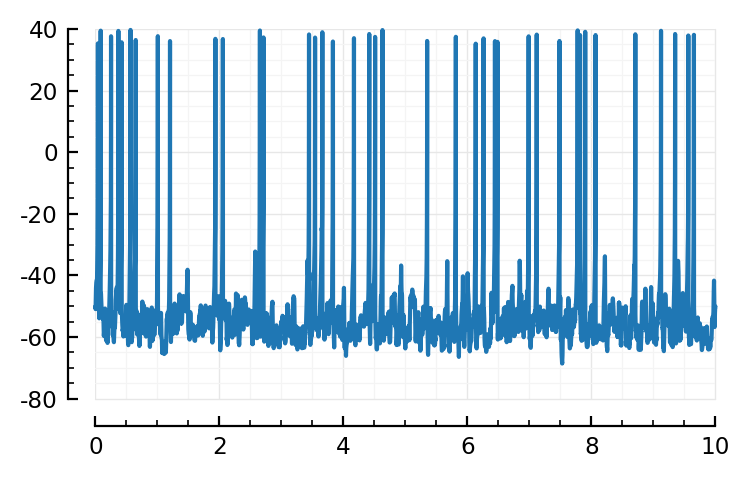

In [95]:
t = linspace(0, duration, Nt)
plotsig(t, v_rec / mV);

In [64]:
aggregate_spikes(inputs::AbstractVector{PoissonInput}) = begin
    spikes = reduce(vcat, pi.sq.spikes for pi in inputs)
    return sort!(spikes)
    # mergesort might be faster than default of quicksort
    # .. but then specifying that no sub-sort recursion needed...
    # https://github.com/vvjn/MergeSorted.jl
    # via https://stackoverflow.com/a/48772313/2611913
    # "5x faster than sort!(), and 2x faster and less memory than sort!(alg=MergeSort)"
    # even better, i do self :))
    #  > alloc array with len (sum(lengths))
    #  > fill one by one, each time lookin through each of the inputs (an index pointer for each -- ooh can use SpikeFeed :))
end

aggregate_spikes(inputs);

In [10]:
izh.generated_func

:((diff, vars, params)->begin
          @unpack (v, u, I_syn, gₑ, gᵢ) = vars
          @unpack (C, Eᵢ, Eₑ, a, b, k, vᵣ, vₗ, vₜ, τ) = params
          diff.v = ((k * (v - vₗ) * (v - vₜ) - u) - I_syn) / C
          diff.u = a * (b * (v - vᵣ) - u)
          vars.I_syn = gₑ * (v - Eₑ) + gᵢ * (v - Eᵢ)
          diff.gₑ = -gₑ / τ
          diff.gᵢ = -gᵢ / τ
      end)